In [1]:
import warnings
import sys

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    # Hides warnings about sklearn/externals/{six,joblib} deprecation in 0.23
    import mglearn 
    
sys.path.append("..")
from src.io import get_raw_structured_dataset, Dataset, XY, get_label_title
from src.processing import process_string_to_tokens, normalize_word, TOKENIZED_STOP_WORDS, NLTK_STOP_WORDS

# Data preprocessing and Feature Extraction
##### Split and shuffle the dataset

In [2]:
raw_dataset = get_raw_structured_dataset()
print(f"Training dataset size: {len(raw_dataset.trn.x)}")
print(f"Testing dataset size: {len(raw_dataset.tst.x)}")

Training dataset size: 9595
Testing dataset size: 1067


##### Clean data and Extract features

In [3]:
class Tokenizer(object):
    def __call__(self, string):
        def normalize_word_fun(token): 
            # Returning the token untouched if it is a stop-word
            #  solves error "UserWarning: Your stop_words may be 
            #  inconsistent with your preprocessing.". 
            return normalize_word(token) if token not in NLTK_STOP_WORDS else token
            
        # Stop words are filtered by the Vectorizer.
        return process_string_to_tokens(string, remove_stop_words=False,
                                        normalize_word_fun=normalize_word_fun)

vectorizer = CountVectorizer(min_df=5, 
                             ngram_range=(1, 2),
                             tokenizer=Tokenizer(),
                             stop_words=TOKENIZED_STOP_WORDS,
                             lowercase=True)
vectorizer.fit(raw_dataset.trn.x)
vectorized_dataset = Dataset(trn=XY(x=vectorizer.transform(raw_dataset.trn.x), y=raw_dataset.trn.y),
                             tst=XY(x=vectorizer.transform(raw_dataset.tst.x), y=raw_dataset.tst.y))
# Show result
print(repr(vectorized_dataset.trn.x))

<9595x4018 sparse matrix of type '<class 'numpy.int64'>'
	with 85597 stored elements in Compressed Sparse Row format>


In [4]:
amount = 10
feature_tokens = vectorizer.get_feature_names()
print(f"First {amount} selected features ({len(feature_tokens)} in total):")
print(*[f"{id_+1}. {a}" for id_, a in enumerate(feature_tokens[:amount])], sep='\n')

First 10 selected features (4018 in total):
1. abandon
2. abil
3. abl
4. abli
5. absolut
6. absorb
7. abstract
8. absurd
9. absurdist
10. abus


# Training 
### Run the training
##### Train the Naive Bayes Classifier

In [5]:
param_grid = {'C': [0.01, 0.1]}
grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5, n_jobs=-1)
grid.fit(vectorized_dataset.trn.x, vectorized_dataset.trn.y)
classifier = grid.best_estimator_

# Print initial and selected parameters of training
print(repr(grid))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
Best cross-validation score: 0.74
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1

##### Show most informative features

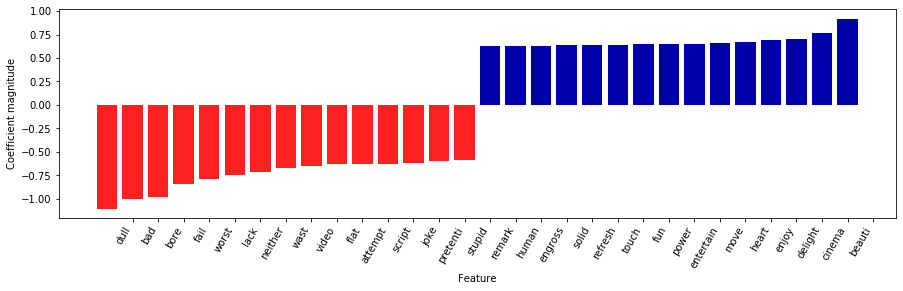

In [6]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_tokens, n_top_features=15)
plt.show()

# Performance evaluation
##### Test set accuracy

In [7]:
classifier.predict(vectorized_dataset.tst.x)
test_accuracy = classifier.score(vectorized_dataset.tst.x, vectorized_dataset.tst.y)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

Test set accuracy: 73.95%


# Deployment
##### Example prediction

In [8]:
input_text = "This movie was boring..."

def predict(input_text):
    model_input = vectorizer.transform([input_text])
    return classifier.predict(model_input)[0]

predicted_label = predict(input_text)
predicted_label_title = get_label_title(predicted_label)
print(f'Sentence "{input_text}" is classified as {predicted_label_title}')

Sentence "This movie was boring..." is classified as Negative
